# Линейная регрессия и `sklearn`

В этой домашней работе:
* Обучим линейную регрессию для предсказания цены дома;
* Научимся работать с разными типами признаков;
* Поймем, в чем отличие между разными регуляризаторами;
* Научимся пользоваться основными инструментами в `sklearn`: моделями, трансформерами и pipeline;
* Обсудим преобразования признаков и целевой переменной, которые могут помочь в обучении линейных моделей.

Скачайте тренировочную и тестовую выборку из сорвенования на kaggle: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview).
Разместите данные рядом с тетрадкой или поправьте пути при их чтении.

In [ ]:
# Чтобы не перегружать ячейки с кодом, вынесем сюда все импорты

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, PolynomialFeatures, StandardScaler

sns.set_theme(style="darkgrid")
warnings.simplefilter("ignore")
%matplotlib inline

## Часть 0. Введение в линейные модели

Напомним, что линейная регрессия &mdash; это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию &mdash; значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее будет мало толку. Такую модель называют *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость
$$y(x) = \cos(1.5\pi x)$$
$y$ &mdash; целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечное количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой &mdash;  $\{x\}$, для второй &mdash; $\{x, x^2, x^3, x^4\}$, для третьей &mdash; $\{x, \dots, x^{20}\}$.

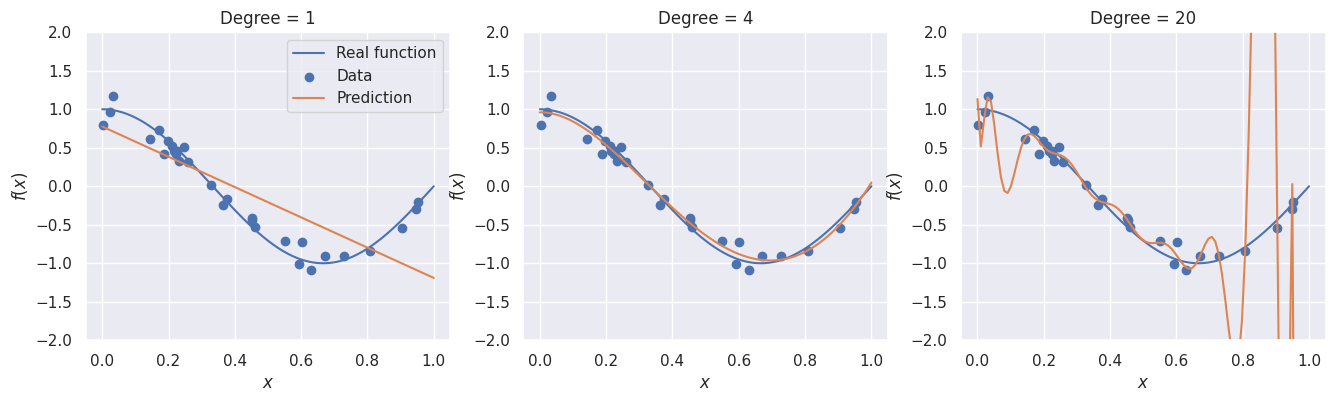

In [ ]:
np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree, include_bias=False).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree, include_bias=False).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

**Вопрос 1**: Почему первая модель получилась плохой, а третья переобучилась?

**Ответ**: Первая модель получилась плохой, потому что прямая слишком простая для того, чтобы подстроиться под косинусоиду, то есть будут слишком грубые предсказания. Третья переобучилась, так как из-за большого количества степеней она становится очень гибкой и сильно подстраивается под обучающие данные, поэтому на новых данных она покажет плохие результаты.

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связаны с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ &mdash; коэффициентом регуляризации.

**Вопрос 2**: Почему большие веса в линейной модели &mdash; плохо?

**Ответ**: Потому что большие веса могут говорить о том, что модель подстроилась под выбросы.

**Вопрос 3**: Почему регуляризовать $w_0$ &mdash; плохая идея?

**Ответ**: Потому что он не связан с признаками (является свободным членом) и отвечает за вертикальный сдвиг предсказаний модели, поэтому регуляризация $w_0$ может привести разве что к искажению предсказаний.

**Вопрос 4**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? Что будет, если $\lambda$ сделать слишком большим?

**Ответ**: $\lambda$ влияет на то, какой штраф получит модель за слишком большие веса. Если $\lambda$ уменьшать, влияние регуляризации будет становиться меньше и меньше, а риск переобучения больше. Если $\lambda$ сделать слишком большим, модель начнет уменьшать веса, пока они не дойдут до 0, то есть влияние признаков в целом перестанет учитываться.

## Часть 1. Загружаем данные

In [ ]:
train_data = pd.read_csv("train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train_data.shape

(1460, 81)

In [ ]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле `id`. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Выделим валидационную выборку, а также отделим значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа `id` могут вызвать переобучение модели (не обязательно линейной)?

**Ответ**: Потому что модель начнет искать зависимости там, где их нет, ведь id никак не влияет на стоимость квартиры.

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

**Ответ**: Чтобы на этих данных подбирать гиперпараметры.

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

**Ответ**: Это позволяет при разных запусках получать одни и те же наборы данных.

In [ ]:
train_data = train_data.drop(columns=["Id"])

X = train_data.drop(columns=["SalePrice"])
y = train_data["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

Посмотрим сначала на значения целевой переменной.

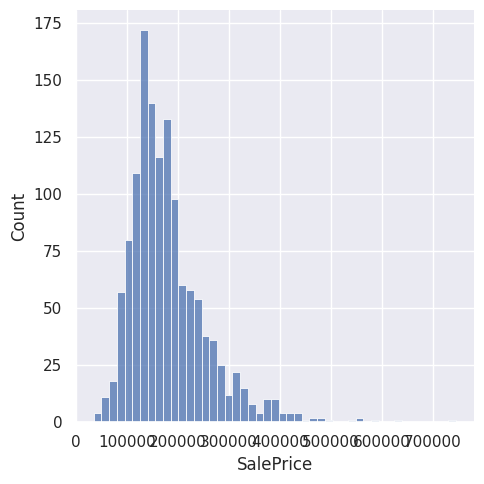

In [ ]:
sns.displot(y_train)

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

**Вопрос**: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

**Ответ**: 1 - одна величина линейно возрастает с увеличением другой

-1 - одна величина линейно убывает с увеличением другой

0 - нет линейной зависимости между двумя случайными величинами

In [ ]:
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns
numeric_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
907,50,86.0,11500,7,7,1936,1987,0.0,223,0,...,180,0,0,0,0,322,0,0,6,2006
782,20,67.0,16285,7,5,2001,2002,0.0,0,0,...,605,0,33,0,0,0,0,0,6,2009
952,85,60.0,7200,5,8,1972,2003,0.0,660,0,...,396,192,0,0,0,0,0,0,4,2009
620,30,45.0,8248,3,3,1914,1950,0.0,41,0,...,0,0,0,100,0,0,0,0,9,2008
669,30,80.0,11600,4,5,1922,1950,0.0,0,0,...,252,0,0,67,0,0,0,0,7,2006


Заметим, что в данных присутствуют пропуски, заполним их средним значением по признаку.

**Вопрос**: Как правильно заполнять пропуски для валидационной и тестовой выборки?

**Ответ**: Такие пропуски заполняются средним значением по признаку из тренировочных данных, чтобы не вызвать утечку данных.

In [ ]:
train_mean = numeric_data.mean()

X_train = X_train.fillna(train_mean)
X_val = X_val.fillna(train_mean)

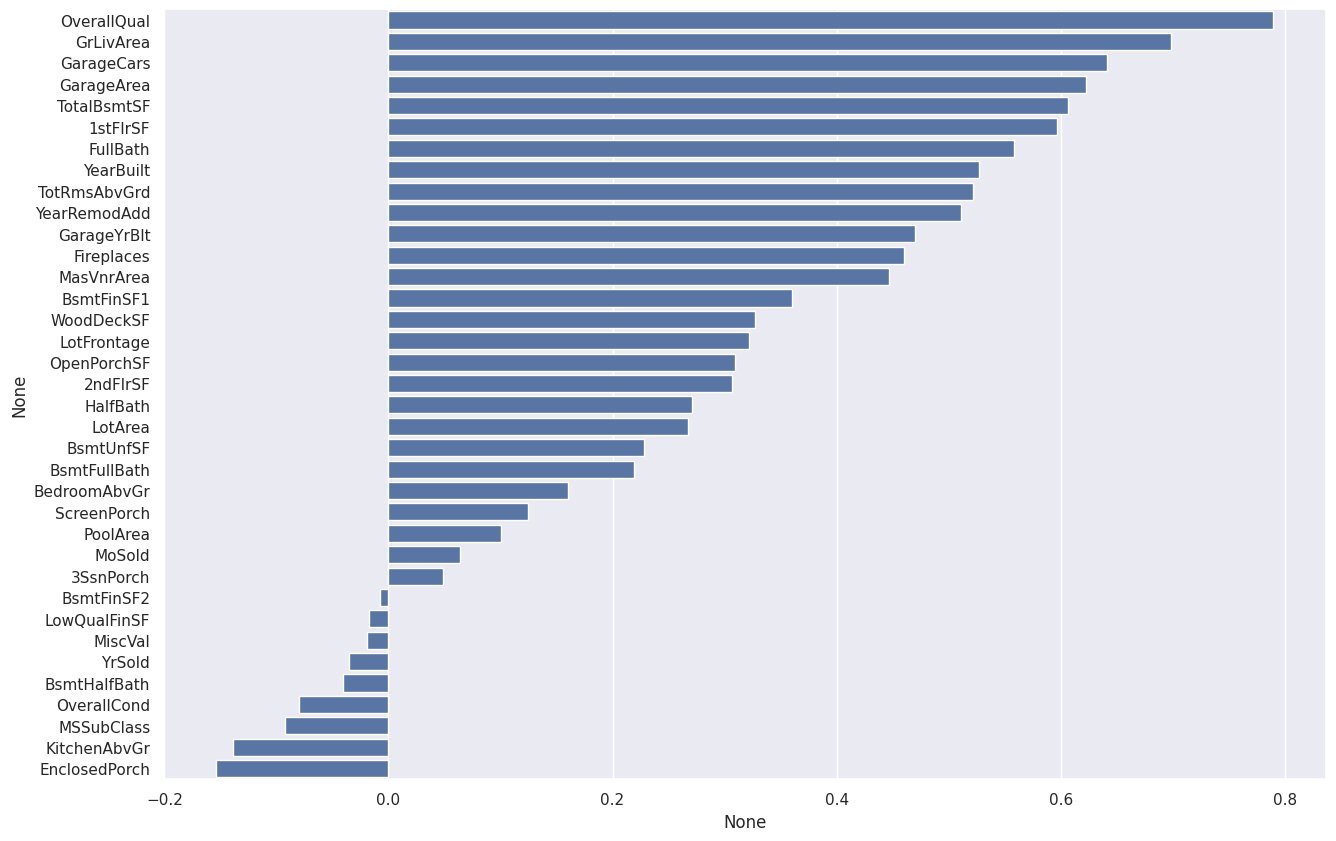

In [ ]:
correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).

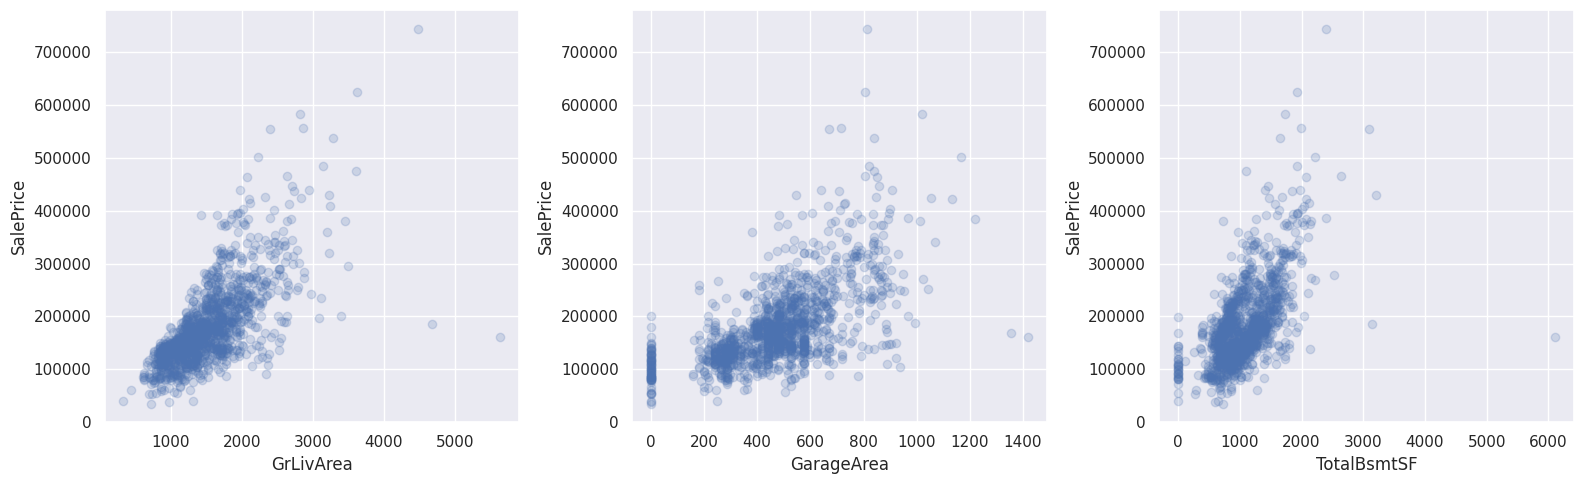

In [ ]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

## Часть 2. Первая модель

*Немного об обучении моделей*. В арсенале ML-специалиста кроме `pandas` и `matplotlib` должны быть библиотеки, позволяющие обучать модели. Для простых моделей (линейные модели, решающее дерево, ...) отлично подходит `sklearn`: в нем очень понятный и простой интерфейс. Несмотря на то, что в `sklearn` есть реализация бустинга и простых нейронных сетей, ими все же не пользуются и предпочитают специализированные библиотеки: `XGBoost`, `LightGBM` и пр. для градиентного бустинга над деревьями, `PyTorch`, и пр. для нейронных сетей. Так как мы будем обучать линейную регрессию, нам подойдет реализация из `sklearn`.

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [ ]:
model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_val[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

Стандартный способ оценить качество регрессии &mdash; **MSE**

In [ ]:
def mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray, squared: bool = True) -> float:
    """Calculate Mean Squared Error

    Args:
        y_true: array with ground truth values, [n_samples,]
        y_pred: array with predicted values, [n_samples,]
        squared: whether to return squared MSE or not

    Returns:
        number, calculated error
    """

    squared_error = (y_true - y_pred) ** 2
    mse = np.mean(squared_error)
    if squared:
      return mse
    else:
      return np.sqrt(mse)


In [ ]:
print("Val RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Val RMSE = 39807.9955
Train RMSE = 33812.0435


Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [ ]:
cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -34142.7733
	-26940.4462
	-44136.7126
	-42722.6346
	-65597.9946
	-42194.3872
	-28881.2199
	-22345.1129
	-27307.1270
	-26632.0690
Mean CV MSE = 36090.0477


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем RMSE (Root Mean Squared Error), хотя в функционале ошибки при обучении модели используется MSE.

$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

**Вопрос**: Почему оптимизация RMSE эквивалентна оптимизации MSE?

**Ответ**: Потому что корень - это монотонная функция, точка минимума для MSE является точкой минимума для RMSE.

Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

**Ответ**: Среднему значению целевой функции.

In [ ]:
best_constant = np.mean(y_train)

In [ ]:
print(
    "Test RMSE with best constant = %.4f"
    % mean_squared_error(y_val, best_constant * np.ones(y_val.shape), squared=False)
)
print(
    "Train RMSE with best constant = %.4f"
    % mean_squared_error(y_train, best_constant * np.ones(y_train.shape), squared=False)
)

Test RMSE with best constant = 95610.2785
Train RMSE with best constant = 77407.3131


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

**Ответ**: Потому что мы еще не масштабировали признаки.

In [ ]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

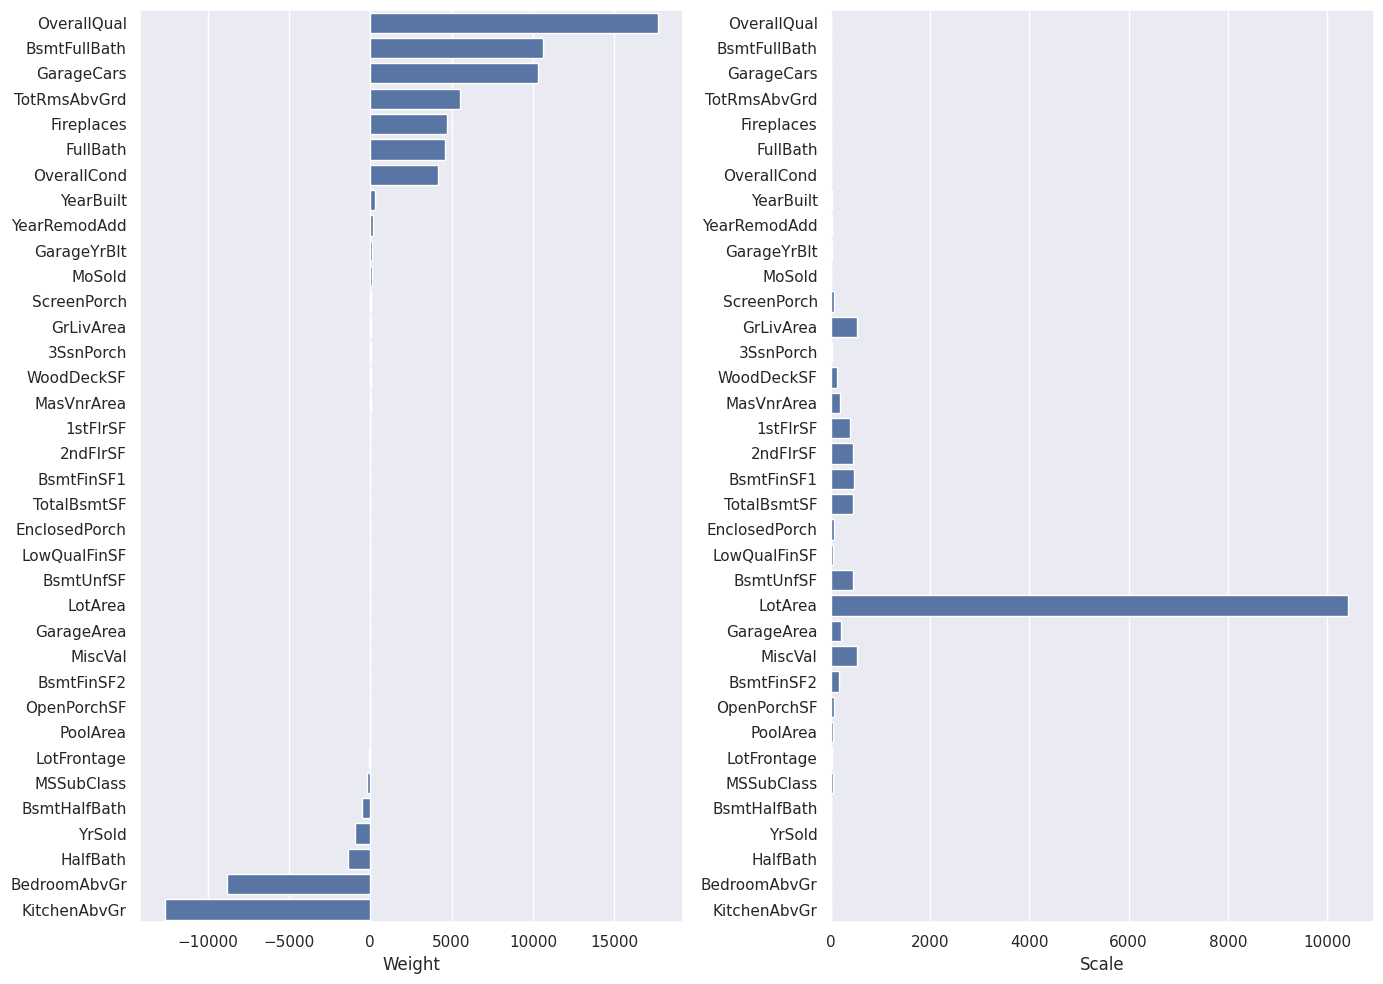

In [ ]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени.

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_val_scaled = scaler.fit_transform(X_val[numeric_features])

In [ ]:
model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))

Test RMSE = 40460.0826
Train RMSE = 33811.9971


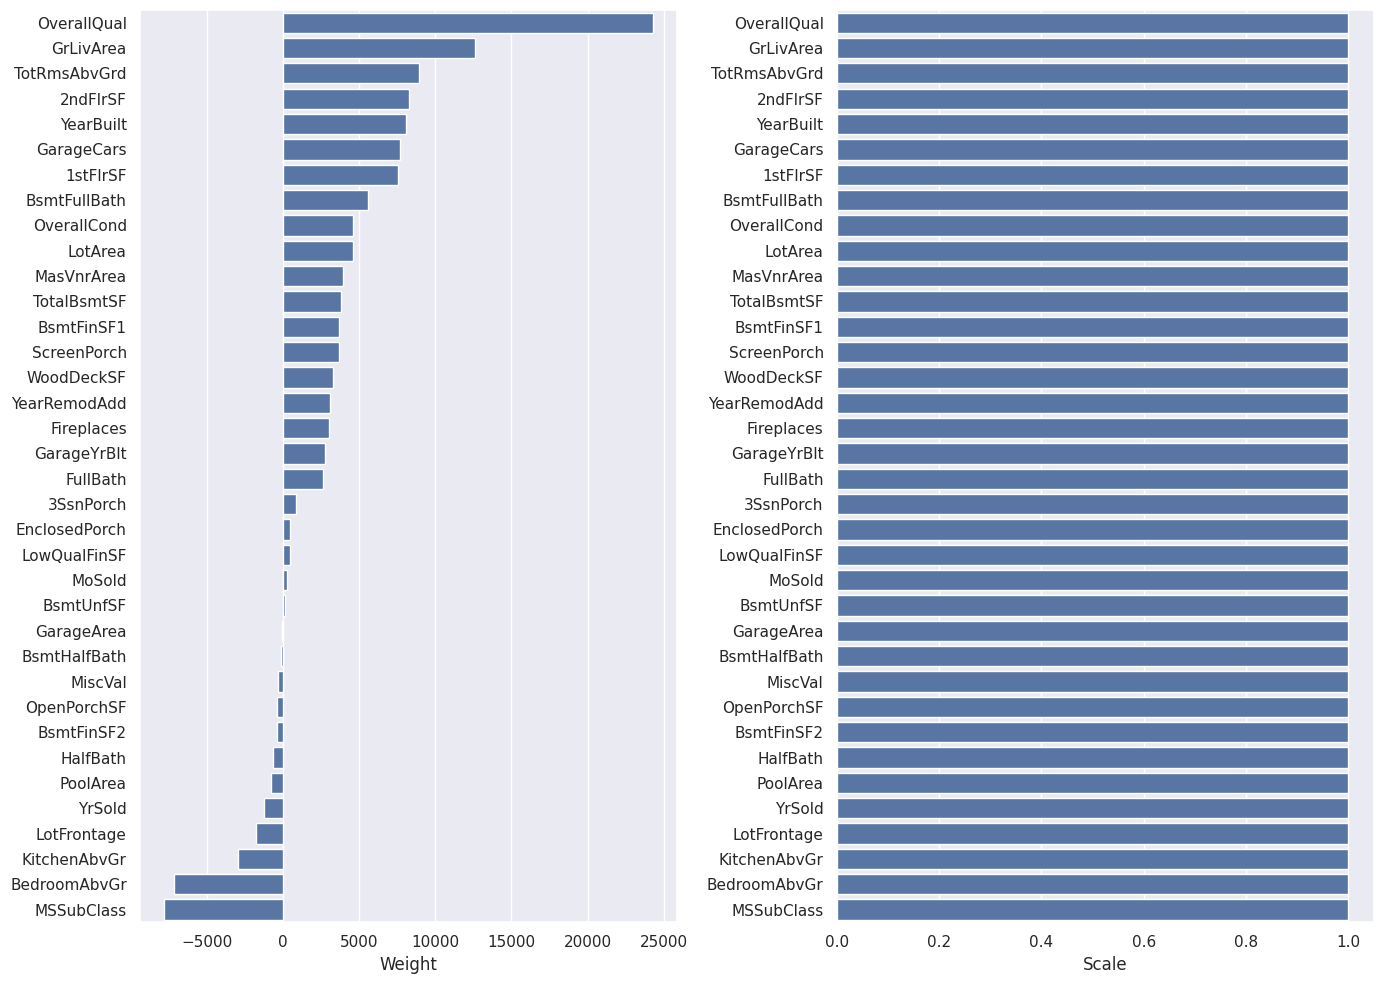

In [ ]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать.

Для начала зададим возможные значения гиперпараметра, воспользуемся `np.logspace`, чтобы узнать оптимальный порядок величины.
Ограничим допустимые значения $10^{-2}$ и $10^{3}$, возьмем $20$ точек.

In [ ]:

alphas = np.logspace(-2, 3, num=20)
assert alphas[0] == 1e-2
assert alphas[-1] == 1e3
assert len(alphas) == 20

alphas

array([1.00000000e-02, 1.83298071e-02, 3.35981829e-02, 6.15848211e-02,
       1.12883789e-01, 2.06913808e-01, 3.79269019e-01, 6.95192796e-01,
       1.27427499e+00, 2.33572147e+00, 4.28133240e+00, 7.84759970e+00,
       1.43844989e+01, 2.63665090e+01, 4.83293024e+01, 8.85866790e+01,
       1.62377674e+02, 2.97635144e+02, 5.45559478e+02, 1.00000000e+03])

Best alpha = 162.3777


Text(0, 0.5, 'CV score')

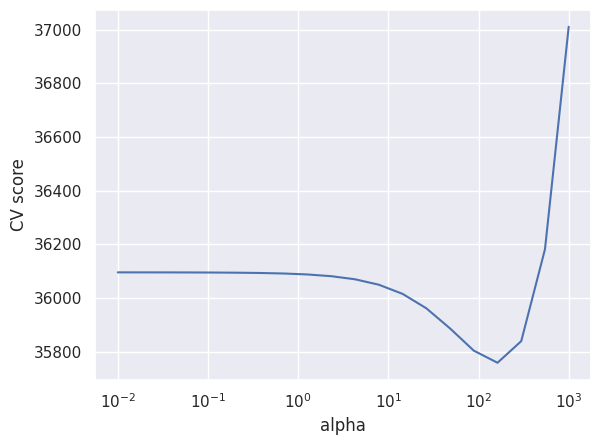

In [ ]:
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

**Вопрос**: Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

**Ответ**: Потому что если подбирать гиперпараметры на обучающей выборке - модель может переобучиться. Тестовая выборка остается для финальной проверки работы модели на реальных данных, иначе произойдет утечка данных.

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [ ]:
simple_pipeline = Pipeline([("scaling", StandardScaler()), ("regression", Ridge(best_alpha))])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_val[numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))

Test RMSE = 40685.6214


## Часть 3. Работаем с категориальными признаками

Сейчас мы явно вытягиваем из данных не всю информацию, что у нас есть, просто потому, что мы не используем часть признаков. Эти признаки в датасете закодированы строками, каждый из них обозначает некоторую категорию. Такие признаки называются категориальными. Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

In [ ]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
907,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,Fin,Fa,TA,Y,NaN,NaN,NaN,WD,Normal
782,RL,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
952,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Detchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
620,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,WD,Normal
669,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,Fa,Y,NaN,NaN,NaN,WD,Normal


В категориальных данных также есть пропуски, заполним их отдельной новой категорией `NotGiven`

In [ ]:
X_train[categorical] = X_train[categorical].fillna('NotGiven')
X_val[categorical] = X_val[categorical].fillna('NotGiven')
X_train[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
907,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,Fin,Fa,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
782,RL,Pave,NotGiven,IR2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
952,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Detchd,Fin,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal
620,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,NotGiven,NotGiven,NotGiven,NotGiven,N,NotGiven,NotGiven,NotGiven,WD,Normal
669,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,Fa,Y,NotGiven,NotGiven,NotGiven,WD,Normal


In [ ]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
702,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,...,BuiltIn,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,New,Partial
596,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,...,Detchd,Unf,TA,Fa,N,NotGiven,NotGiven,NotGiven,WD,Normal
159,RL,Pave,NotGiven,IR1,HLS,AllPub,Corner,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,New,Partial
739,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
151,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,New,Partial


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками &mdash; [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (просто перенумеровывает значения признака натуральными числами) и [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

**Вопрос**: Проинтерпретируйте, что означают веса модели перед OneHot-кодированными признаками. Почему пользоваться `OrdinalEncoder` в случае линейной модели &mdash; скорее плохой вариант? Какие недостатки есть у OneHot-кодирования?

**Ответ**: 1. Если кодируются все значения признака, то вес - это вклад конкретной категории (остальные категории будут равняться 0, поэтому веса перед ними никакого вклада не принесут). Если была выбрана базовая категория, то веса перед остальными категориями показывают разницу с базовой категорией.

2. Линейная модель может учитывать порядок чисел для предсказания и находить в этом зависимость, которой на самом деле нет.

3. Сильно увеличивается размерность пространства.

In [ ]:
column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge())])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Test RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))

Test RMSE = 31367.9610


**Вопрос**: Как вы думаете, почему мы не производим скейлинг OneHot-кодированных признаков?

**Ответ**: Потому что такие признаки уже имеют нужный нам вид в виде 0 или 1 (mean = 0, std = 1).

Посмотрим на размеры матрицы после OneHot-кодирования:

In [ ]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1314, 79)
Size after OneHot: (1314, 302)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором.

**Вопрос**: Каким полезным свойством обладает такой регуляризатор?

**Ответ**: Он зануляет веса, оставляя наиболее значимые, что позволяет избавиться от большого количества признаков.

In [ ]:
column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

lasso_pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso())])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))

RMSE = 30754.2805


In [ ]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 34


Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`.

Best alpha = 127.4275


Text(0, 0.5, 'CV score')

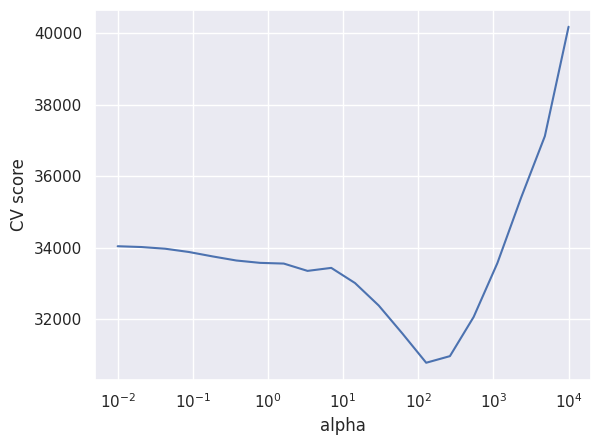

In [ ]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(
    lasso_pipeline, [{"regression__alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1
)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [ ]:
column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso(best_alpha))])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Test RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))

Test RMSE = 31242.7572


In [ ]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 195


Иногда очень полезно посмотреть на распределение остатков. Нарисуем гистограмму распределения квадратичной ошибки на обучающих объектах:

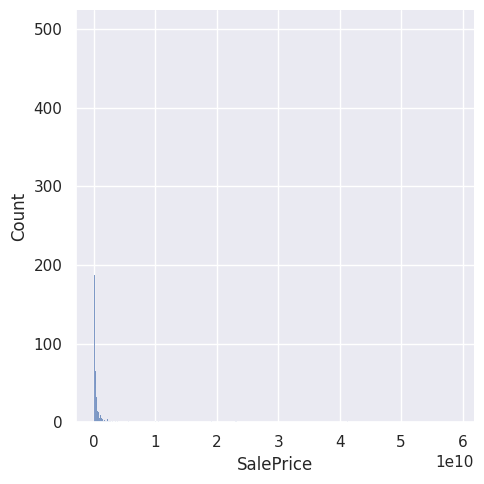

In [ ]:
error = (y_train - model.predict(X_train)) ** 2
sns.displot(error)

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Например, выбросим примеры, остаток у которых больше 0.95-квантили.

In [ ]:
mask = error < np.quantile(error, 0.95)

In [ ]:
column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", Lasso(best_alpha))])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_val)
print("Test RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))

Test RMSE = 31003.4116


In [ ]:
X_train = X_train[mask]
y_train = y_train[mask]

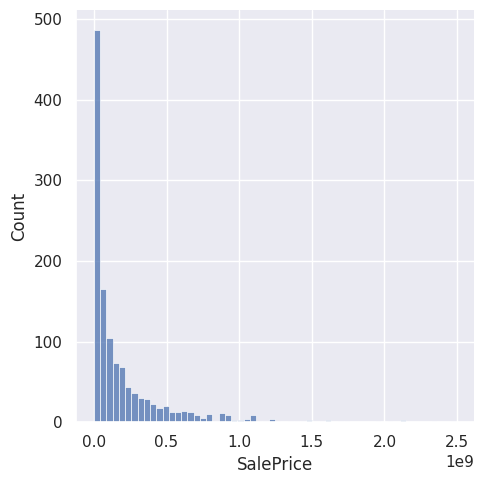

In [ ]:
error = (y_train[mask] - model.predict(X_train[mask])) ** 2
sns.displot(error)

Видим, что качество модели заметно улучшилось! Также бывает очень полезно посмотреть на примеры с большими остатками и попытаться понять, почему же модель на них так сильно ошибается: это может дать понимание, как модель можно улучшить.

## Часть 4. Подготовка данных для линейных моделей

Есть важное понятие, связанное с применением линейных моделей, — *спрямляющее пространство*. Под ним понимается такое признаковое пространство для наших объектов, в котором линейная модель хорошо описывает данные, даёт хорошее качество прогнозов.

Не существует общих рекомендаций о том, как найти спрямляющее пространство для произвольной выборки. Есть лишь некоторые общие советы — например, если добавить в выборку полиномиальных признаков, то скорее всего модель станет работать лучше (если не переобучится). Есть и другие трюки.

У линейных моделей есть огромное преимущество: они имеют мало параметров, а поэтому их можно обучить даже на небольшой выборке. Если выборка большая, то параметры модели получится оценить более надёжно — но в то же время есть риск, что данные будут слишком разнообразными, чтобы линейная модель могла уловить все закономерности в них. Иногда можно улучшить ситуацию путём разбиения признакового пространства на несколько областей и построения своей модели в каждой из них.

Попробуем для примера в нашей задаче разделить выборку на две части по признаку OverallQual. Это один из самых сильных признаков, и, возможно, разбиение по нему даст нам две выборки с заведомо разными ценами на дома.

Для начала вспомним, какое качество получается у обычной гребневой регрессии.

In [ ]:
column_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

pipeline = Pipeline(steps=[("ohe_and_scaling", column_transformer), ("regression", Ridge())])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Test RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))

Test RMSE = 30358.9829


Посмотрим на связь OverallQual и целевой переменной.

Text(0, 0.5, 'SalePrice')

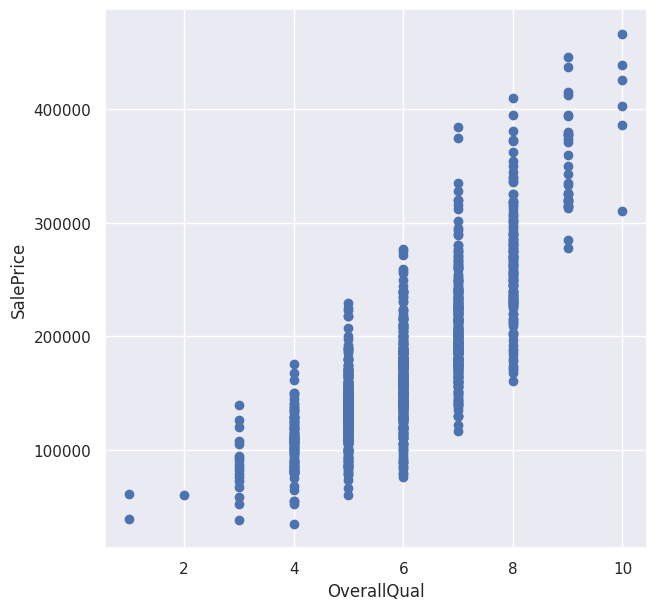

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train["OverallQual"], y_train)
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

In [ ]:
threshold = 5
mask = X_train["OverallQual"] <= threshold
X_train_1 = X_train[mask]
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask]
y_train_2 = y_train[~mask]

In [ ]:
column_transformer1 = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

pipeline1 = Pipeline(steps=[("ohe_and_scaling", column_transformer1), ("regression", Ridge())])

column_transformer2 = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore"), categorical), ("scaling", StandardScaler(), numeric_features)]
)

pipeline2 = Pipeline(steps=[("ohe_and_scaling", column_transformer2), ("regression", Ridge())])


model1 = pipeline1.fit(X_train_1, y_train_1)
model2 = pipeline2.fit(X_train_2, y_train_2)

y_pred_1 = model1.predict(X_val)
y_pred_2 = model2.predict(X_val)
mask_test = X_val["OverallQual"] <= threshold
y_pred = y_pred_1.copy()
y_pred[~mask_test] = y_pred_2[~mask_test]

print("Test RMSE = %.4f" % mean_squared_error(y_val, y_pred, squared=False))

Test RMSE = 29414.2732


Получилось лучше! И это при практически случайном выборе разбиения. Если бы мы поработали над этим получше, то и качество, скорее всего, получилось бы выше.

Перейдём к следующему трюку — бинаризации признаков. Мы выбираем $n$ порогов $t_1, \dots, t_n$ для признака~$x_j$ и генерируем $n+1$ новый признак: $[x_j \leq t_1], [t_1 < x_j \leq t_2], \dots, [t_{n-1} < x_j \leq t_n], [x_j > t_n]$. Такое преобразование может неплохо помочь в случае, если целевая переменная нелинейно зависит от одного из признаков. Рассмотрим синтетический пример.

(-2.0, 2.0)

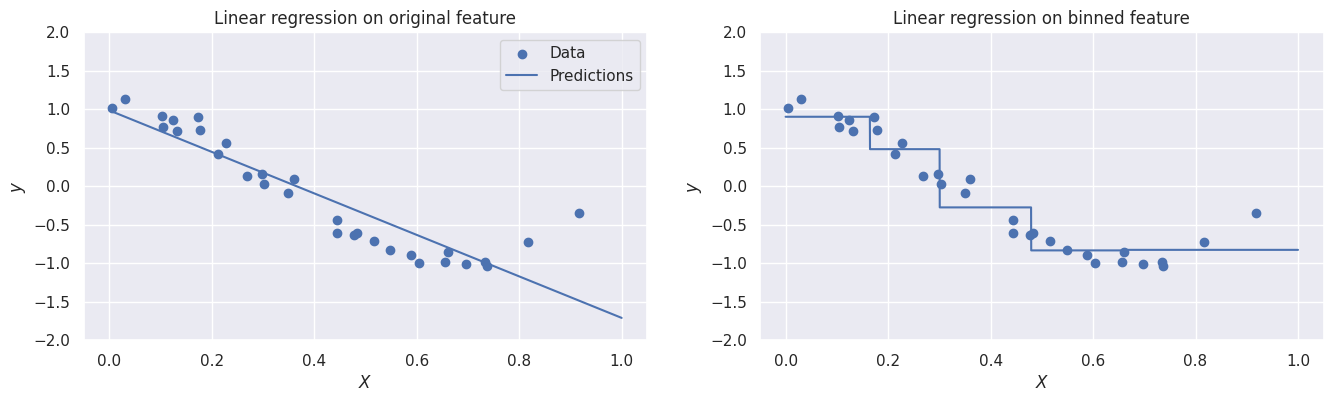

In [ ]:
x_plot = np.linspace(0, 1, 10000)

X = np.random.uniform(0, 1, size=30)
y = np.cos(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)

fig, axs = plt.subplots(figsize=(16, 4), ncols=2)

regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
y_pred_regr = regr.predict(x_plot[:, np.newaxis])
axs[0].scatter(X[:, np.newaxis], y, label="Data")
axs[0].plot(x_plot, y_pred_regr, label="Predictions")
axs[0].legend()
axs[0].set_title("Linear regression on original feature")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$y$")
axs[0].set_ylim(-2, 2)

binner = KBinsDiscretizer(n_bins=5, strategy="quantile")
pipeline = Pipeline(steps=[("binning", binner), ("regression", LinearRegression())])
pipeline.fit(X[:, np.newaxis], y)
y_pred_binned = pipeline.predict(x_plot[:, np.newaxis])
axs[1].scatter(X[:, np.newaxis], y, label="Data")
axs[1].plot(x_plot, y_pred_binned, label="Predictions")
axs[1].set_title("Linear regression on binned feature")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$y$")
axs[1].set_ylim(-2, 2)

Видно, что качество модели существенно возрасло. С другой стороны, увеличилось и количество параметров модели (из-за увеличения числа признаков), поэтому при бинаризации важно контролировать переобучение.

Иногда может помочь преобразование целевой переменной. Может оказаться, что по мере роста признаков целевая переменная меняется экспоненциально. Например, может оказаться, что при линейном уменьшении продолжительности видео число его просмотров растёт экспоненциально. Учеть это можно с помощью логарифмирования целевой переменной — ниже синтетический пример с такой ситуацией.

Text(0, 0.5, '$y$')

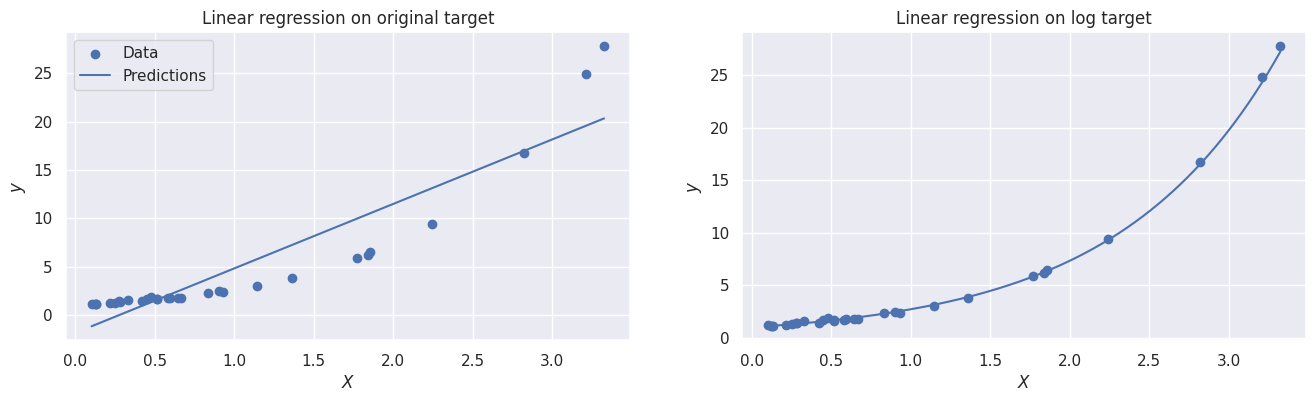

In [ ]:
X = np.random.exponential(1, size=30)
y = np.exp(X) + np.random.normal(scale=0.1, size=X.shape)

x_plot = np.linspace(np.min(X), np.max(X), 10000)

fig, axs = plt.subplots(figsize=(16, 4), ncols=2)

regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
y_pred_regr = regr.predict(x_plot[:, np.newaxis])
axs[0].scatter(X[:, np.newaxis], y, label="Data")
axs[0].plot(x_plot, y_pred_regr, label="Predictions")
axs[0].legend()
axs[0].set_title("Linear regression on original target")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$y$")

y_log = np.log(y)
regr.fit(X[:, np.newaxis], y_log)
y_pred_log = np.exp(regr.predict(x_plot[:, np.newaxis]))
axs[1].scatter(X[:, np.newaxis], y, label="Data")
axs[1].plot(x_plot, y_pred_log, label="Predictions")
axs[1].set_title("Linear regression on log target")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$y$")

Но, конечно, вряд ли в реальных данных будет действительно экспоненциальная связь между целевой переменной и линейной комбинацией признаков. Тем не менее, логарифмирование всё равно может помочь.

## Часть 5. Свободный полет

Оцените качество лучшей модели на тестовой выборке. Сравните с результатами на leaderboard, вы также можете отправить свое решение.
Вы можете продолжить экспериментировать и постараться получить качество как можно выше.

In [ ]:
test_data = pd.read_csv("test.csv")

In [ ]:
test_data = test_data.drop(columns=["Id"])

In [ ]:
numeric_data_test = test_data.select_dtypes([np.number])
numeric_features_test = numeric_data_test.columns

In [ ]:
test_data[numeric_features_test] = test_data[numeric_features_test].fillna(train_mean)

In [ ]:
categorical_test = list(test_data.dtypes[test_data.dtypes == "object"].index)

In [ ]:
test_data[categorical_test] = test_data[categorical_test].fillna('NotGiven')

In [ ]:
y_pred_1 = model1.predict(test_data)
y_pred_2 = model2.predict(test_data)
mask_test = test_data["OverallQual"] <= threshold
y_pred = y_pred_1.copy()
y_pred[~mask_test] = y_pred_2[~mask_test]

In [ ]:
predictions = pd.read_csv("sample_submission.csv")

predictions["SalePrice"] = y_pred_test
predictions.to_csv("sample_submission.csv", index=False)

Итоговый score:
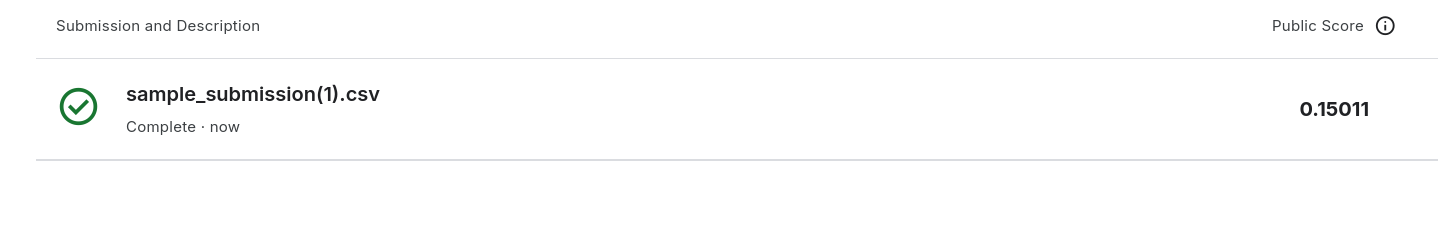